## Homework 4

Use this notebook as a starter

In [251]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [252]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [253]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [254]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [255]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [256]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [257]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [258]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int32
dtype: object

In [259]:
df.head().T

,0,1,2,3,4
seniority,9,17,10,0,0
home,rent,rent,owner,rent,rent
time,60,60,36,60,36
age,30,58,46,24,26
marital,married,widow,married,single,single
records,no,no,yes,no,no
job,freelance,fixed,freelance,fixed,fixed
expenses,73,48,90,63,46
income,129,131,200,182,107
assets,0,0,3000,2500,0


In [260]:
df.columns

Index(['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
       'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'],
      dtype='object')

In [261]:
categorical = ['home',  'marital', 'records', 'job','default']

In [262]:
numerical = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [263]:
from sklearn.model_selection import train_test_split

In [264]:
df_full_train, df_test = train_test_split(df, test_size= 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state = 1)

In [265]:
df_full_train = df_full_train.reset_index(drop = True)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

full_y_train = df_full_train.default.values
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [266]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [267]:
auc_val = []
for numeric in numerical:
    fpr, tpr, thresholds = roc_curve(df_train['default'], df_train[numeric])
    roc_val = auc(fpr, tpr)
    if roc_val < 0.5:
            fpr, tpr, thresholds = roc_curve(df_train['default'], -df_train[numeric])
            roc_val = auc(fpr, tpr)
                   
    auc_val.append((roc_val.round(2), numeric))

In [268]:
columns = ['auc', 'numeric']

df_scores = pd.DataFrame(auc_val, columns = columns)
    
df_scores


,auc,numeric
0,0.71,seniority
1,0.56,time
2,0.57,age
3,0.50,expenses
4,0.68,income
5,0.65,assets
6,0.50,debt
7,0.59,amount
8,0.50,price


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [269]:
from sklearn.feature_extraction import DictVectorizer 
from sklearn.linear_model import LogisticRegression

In [270]:
del df_train['default']
del df_val['default']
del df_test['default']

In [271]:
sel_col = ['seniority', 'income', 'assets', 'records', 'job', 'home']
train_dicts = df_train[sel_col].to_dict(orient = 'records')

dv = DictVectorizer(sparse = False)

X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [272]:
val_dicts = df_val[sel_col].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

y_pred = model.predict(X_val)

fpr, tpr, thresholds =roc_curve(y_val, y_pred)

auc(fpr, tpr).round(3)

0.682

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [273]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

In [274]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

In [275]:
precision, recall, thresholds

(array([0.27609428, 0.64044944, 1.        ]),
 array([1.        , 0.46341463, 0.        ]),
 array([0, 1]))

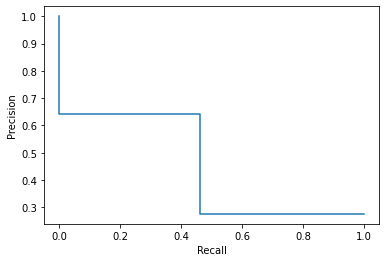

In [276]:
pr_recall_map = PrecisionRecallDisplay(precision, recall).plot()

In [277]:
thresholds = np.linspace(0.0, 1.0, 100).round(2)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [278]:
def precision_recall_df(y_target, y_pred):
    vals = []

    thresholds = np.linspace(0.0, 1.0, 100).round(2)

    for val in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= val)
        predict_negative = (y_pred < val)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
       

        vals.append((val, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_vals = pd.DataFrame(vals, columns = columns)

    df_vals['precision'] = df_vals.tp / (df_vals.tp + df_vals.fp)

    df_vals['recall'] = df_vals.tp / (df_vals.tp +  df_vals.fn)
    
    return df_vals

In [279]:
df_results =precision_recall_df(y_val, y_pred)
df_results

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,246,645,0,0,0.276094,1.000000
1,0.01,114,64,132,581,0.640449,0.463415
2,0.02,114,64,132,581,0.640449,0.463415
3,0.03,114,64,132,581,0.640449,0.463415
4,0.04,114,64,132,581,0.640449,0.463415
...,...,...,...,...,...,...,...
95,0.96,114,64,132,581,0.640449,0.463415
96,0.97,114,64,132,581,0.640449,0.463415
97,0.98,114,64,132,581,0.640449,0.463415
98,0.99,114,64,132,581,0.640449,0.463415


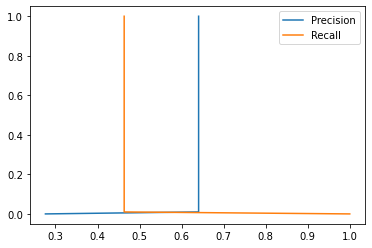

In [280]:
plt.plot(df_results.precision, df_results.threshold, label = 'Precision')
plt.plot(df_results.recall, df_results.threshold, label = 'Recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [281]:
df_results['F1'] = 2*df_results.precision * df_results.recall / (df_results.precision + df_results.recall)
df_results.F1.max()

0.5377358490566039

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [287]:
def train_M(df_train, y_train, C=1.0):
    dicts = df_train[sel_col].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [294]:
def predict(df, dv, model):
    dicts = df[sel_col].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [290]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc

In [295]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
auc_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.default.values
    y_val = df_val.default.values
    
       
    dv, model = train_M(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)
    
np.std(auc_scores)

0.037814990359556246

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [310]:
!pip install tqdm
from tqdm.auto import tqdm

In [311]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    auc_scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.default.values
        y_val = df_val.default.values
    
       
        dv, model = train_M(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    
    print(f'C = {C}, Std: {np.std(auc_scores).round(6)}, Mean: {np.mean(auc_scores).round(6)}')
    

  0%|          | 0/4 [00:00<?, ?it/s]

C = 0.01, Std: 0.024899, Mean: 0.795251
C = 0.1, Std: 0.015813, Mean: 0.810978
C = 1, Std: 0.037815, Mean: 0.795623
C = 10, Std: 0.03817, Mean: 0.795889


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.